**In this notebook, the 'Stabilizers' is preprocessed using .cat.codes (assign each category a code), while in the Task_b notebook make it into dummy** 

In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(rc={'figure.figsize':(11, 4)})
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.use_inf_as_na = True
pd.options.mode.chained_assignment = None 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

## Data Load and Preprocessing

In [21]:
data = pd.read_csv('Eniram Data Engineer Assignment 2019.csv', index_col='Time',  
                   parse_dates=['Time'], infer_datetime_format=True)
data_origin = data.copy(deep=True)
print('Shape:',data.shape)
data.head(3)

Shape: (4392, 7)


,Stabilizers (boolean),Current (nm/h),Speed (nm/h),Power (MW),Wind speed (m/s),Sea temperature (Celsius),Ship name
Time,,,,,,,
2018-04-25 00:00:00,0.0,0.281,11.019,6.096,12.593,25.57,M/S Albatross
2018-04-25 01:00:00,0.0,0.263,11.137,6.058,14.559,25.60,M/S Albatross
2018-04-25 02:00:00,0.0,0.167,11.133,6.074,10.717,25.65,M/S Albatross


In [22]:
data.columns.values

array(['Stabilizers (boolean)', 'Current (nm/h)', 'Speed (nm/h)',
       'Power (MW)', 'Wind speed (m/s)', 'Sea temperature (Celsius)',
       'Ship name'], dtype=object)

In [23]:
features = data.drop(['Power (MW)','Ship name'],axis=1).columns.values.tolist()
cat_features = ['Stabilizers (boolean)'] 
num_features = [i for i in features if i not in cat_features]
target = 'Power (MW)'

In [24]:
## Check missing values
data.isna().sum()

Stabilizers (boolean)        1464
Current (nm/h)                  0
Speed (nm/h)                   16
Power (MW)                      5
Wind speed (m/s)                0
Sea temperature (Celsius)    1469
Ship name                       0
dtype: int64

in Task a, we have checked the missing values by vessels.

Albatross misses 15 'Speed' data points

Star misses 3 'Power', 5 'Sea temperature' data points

Aurora has no 'Stabilizers' and 'Sea temperature' data, and misses 1 'Speed', 2'Power' data points

In [25]:
# Stabilizers: null values are set as -1 (categorical variable) 
data['Stabilizers (boolean)'].fillna(-1,inplace=True)
data['Stabilizers (boolean)']=data['Stabilizers (boolean)'].astype('int')
data['Stabilizers (boolean)'] = data['Stabilizers (boolean)'].map({1:'On',0:'Off',-1:'Unknown'}) 

## Machine learning

**Get relationship between features and target**

### Preprocessing for ML

In [26]:
data.isna().sum()

Stabilizers (boolean)           0
Current (nm/h)                  0
Speed (nm/h)                   16
Power (MW)                      5
Wind speed (m/s)                0
Sea temperature (Celsius)    1469
Ship name                       0
dtype: int64

In [27]:
# Convert categorical variable 
data['Stabilizers (boolean)'] = data['Stabilizers (boolean)'].astype('category').cat.codes
data.head()

,Stabilizers (boolean),Current (nm/h),Speed (nm/h),Power (MW),Wind speed (m/s),Sea temperature (Celsius),Ship name
Time,,,,,,,
2018-04-25 00:00:00,0,0.281,11.019,6.096,12.593,25.57,M/S Albatross
2018-04-25 01:00:00,0,0.263,11.137,6.058,14.559,25.60,M/S Albatross
2018-04-25 02:00:00,0,0.167,11.133,6.074,10.717,25.65,M/S Albatross
2018-04-25 03:00:00,0,0.298,11.102,6.076,8.846,25.77,M/S Albatross
2018-04-25 04:00:00,0,0.116,9.384,4.109,10.040,26.10,M/S Albatross


In [28]:
# Drop the null values of power (target)
data.dropna(subset=['Power (MW)'],inplace=True)

# Only 16 speed points missing, drop those rows.
data.dropna(subset=['Speed (nm/h)'],inplace=True)

data[data[['Sea temperature (Celsius)']].isnull().any(axis=1)]['Ship name'].unique()

array(['M/S Star', 'M/S Aurora'], dtype=object)

For the 'Sea temperature' data

Try: 
* v1: Drop 'Sea temp', not to consider its impact 
* v2: Drop 'Sea temp' null rows

( Since the Aurora misses all the 'Sea temp' data and thus personally I think it is meaningless to fill the null values with a certain method)

In [29]:
# v1: Drop 'Sea temp', not to consider its impact
data_v1 = data.drop(['Sea temperature (Celsius)'],axis=1)
print('shape of data_v1: ', data_v1.shape)
# v2:  Drop 'Sea temp' null rows
data_v2 = data.dropna(subset=['Sea temperature (Celsius)'])
print('shape of data_v2: ', data_v2.shape)

shape of data_v1:  (4371, 6)
shape of data_v2:  (2906, 7)


In [30]:
from sklearn.model_selection import train_test_split
def partition_data(df, features, target, test_size):
    
    X_train, X_test, y_train, y_test = train_test_split(df[features],df[target], 
                                                        stratify=df['Ship name'], 
                                                        test_size = test_size, random_state = 0)
    print("X_train : " + str(X_train.shape))
    print("X_test : " + str(X_test.shape))
    print("y_train : " + str(y_train.shape))
    print("y_test : " + str(y_test.shape))
    
    return X_train, X_test, y_train, y_test

In [31]:
v1_features = data_v1.drop(['Power (MW)','Ship name'],axis=1).columns.values.tolist()
v2_features = data_v2.drop(['Power (MW)','Ship name'],axis=1).columns.values.tolist()
print('v1')
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = partition_data(data_v1,v1_features,
                                                              target,0.2)
print('v2')
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = partition_data(data_v2,v2_features,
                                                              target,0.2)

v1
X_train : (3496, 4)
X_test : (875, 4)
y_train : (3496,)
y_test : (875,)
v2
X_train : (2324, 5)
X_test : (582, 5)
y_train : (2324,)
y_test : (582,)


In [32]:
# Define error measure RMSE
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv(model, X, y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring = scorer, cv = 10))
    return rmse

In [33]:
def make_prediction(clf, clf_name, X_train, X_test, y_train, y_test, fig_name=None):
    
    clf.fit(X_train, y_train)

    # Look at cv results on training and validation set
    print("RMSE on Training set :", rmse_cv(clf, X_train, y_train).mean())
    print("RMSE on Test set :", rmse_cv(clf, X_test, y_test).mean())
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    plt.style.use('default')
    fig, axes = plt.subplots(1,2,figsize=(16,6))

    # Plot residuals
    axes[0].scatter(y_train_pred, y_train_pred - y_train, label = "Training data")
    axes[0].scatter(y_test_pred, y_test_pred - y_test, label = "Validation data")
    axes[0].set_title('Residuals')
    axes[0].set_xlabel("Predicted values")
    axes[0].set_ylabel("Residuals")
    axes[0].legend(loc = "upper left")
    axes[0].grid(True)
    # Plot predictions
    axes[1].scatter(y_train_pred, y_train, marker = "o", label = "Training data")
    axes[1].scatter(y_test_pred, y_test,  marker = "o", label = "Validation data")
    axes[1].set_title('Predictions')
    axes[1].set_xlabel("Predicted values")
    axes[1].set_ylabel("Real values")
    axes[1].legend(loc = "upper left")
    axes[1].grid(True)
    
    fig.suptitle(clf_name)
    
    if fig_name is not None:
        plt.savefig(fig_name)
    
    return axes

### Linear Regression

Coefficients can show the relationship between target and features

In [34]:
from sklearn.linear_model import LinearRegression
# Linear Regression
lr = LinearRegression()

### V1

RMSE on Training set : 5.958998499422333
RMSE on Test set : 6.258254161561977


array([<matplotlib.axes._subplots.AxesSubplot object at 0x2ae117f39a90>,
      dtype=object)

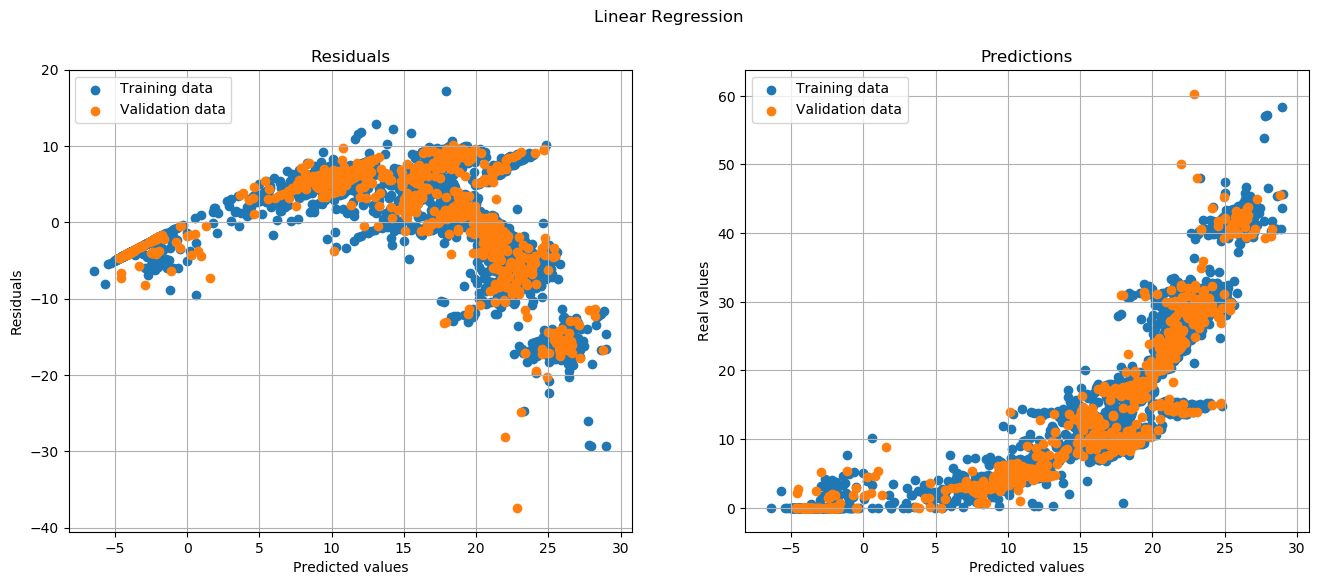

In [35]:
make_prediction(lr, 'Linear Regression', X_train_v1, X_test_v1, y_train_v1, y_test_v1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Stabilizers (boolean)   -1.085094
Current (nm/h)          -0.705159
Speed (nm/h)             1.332459
Wind speed (m/s)        -0.003893
dtype: float64


Text(0.5,1,'Coefficients in the Logistic regression')

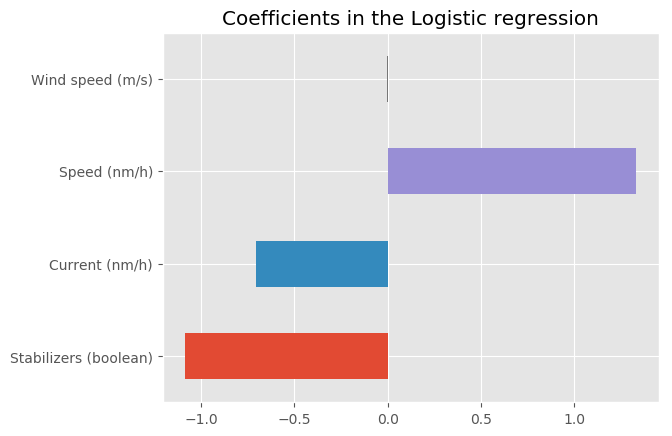

In [36]:
plt.style.use('ggplot')
lr.fit(X_train_v1, y_train_v1)
# Plot important coefficients
coefs = pd.Series(lr.coef_, index = X_train_v1.columns)
print(coefs)
# print("classifer picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
#       str(sum(coefs == 0)) + " features")
# imp_coefs = pd.concat([coefs.sort_values().head(10),
#                      coefs.sort_values().tail(10)])
imp_coefs = coefs
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Logistic regression")
plt.show()

### V2

RMSE on Training set : 6.391826326021007
RMSE on Test set : 6.610245840605406


array([<matplotlib.axes._subplots.AxesSubplot object at 0x2ae120442d68>,
      dtype=object)

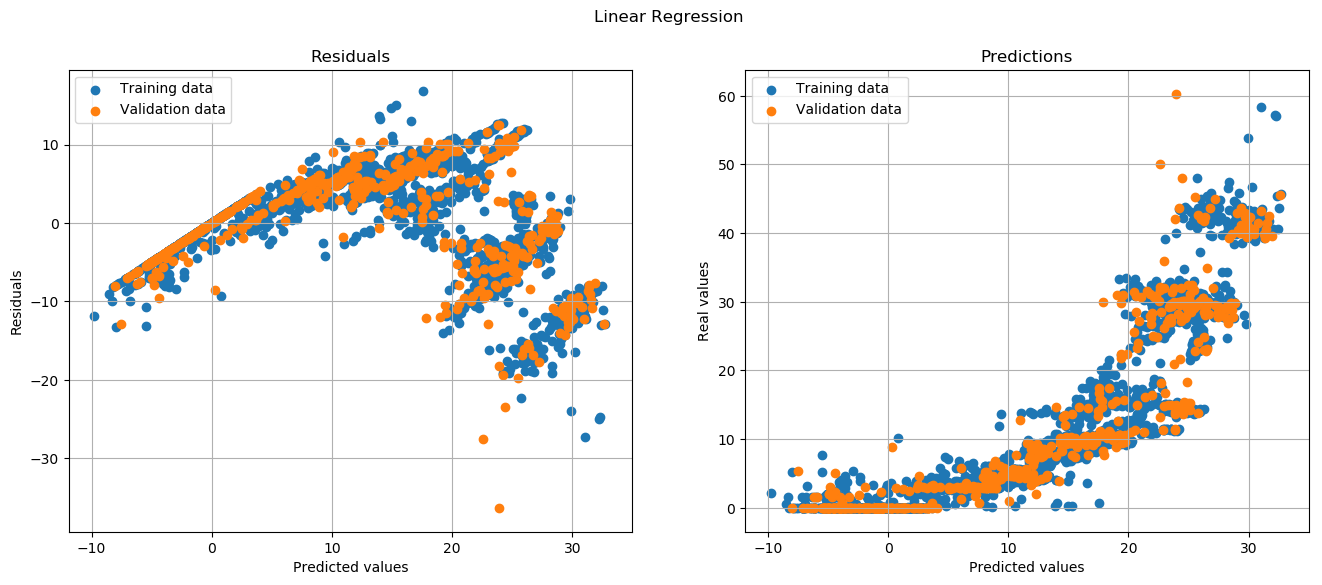

In [37]:
make_prediction(lr, 'Linear Regression', X_train_v2, X_test_v2, y_train_v2, y_test_v2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Stabilizers (boolean)        1.398157
Current (nm/h)              -0.804324
Speed (nm/h)                 1.411744
Wind speed (m/s)             0.010055
Sea temperature (Celsius)    0.621361
dtype: float64


Text(0.5,1,'Coefficients in the Logistic regression')

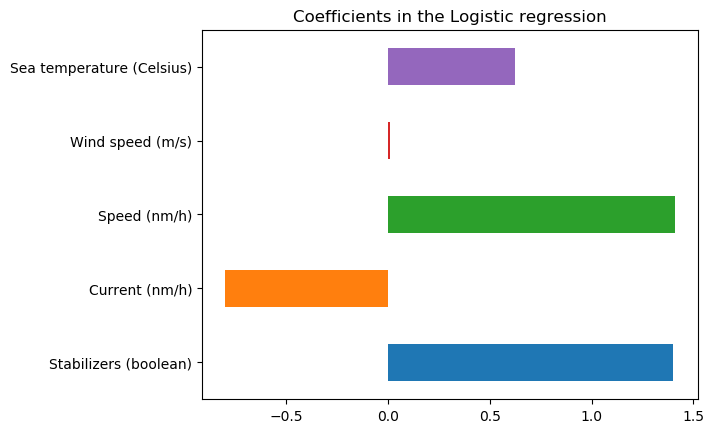

In [38]:
lr.fit(X_train_v2, y_train_v2)
# Plot important coefficients
coefs = pd.Series(lr.coef_, index = X_train_v2.columns)
print(coefs)
# print("classifer picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
#       str(sum(coefs == 0)) + " features")
# imp_coefs = pd.concat([coefs.sort_values().head(10),
#                      coefs.sort_values().tail(10)])
imp_coefs = coefs
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Logistic regression")
plt.show()

### Random forest

Feature importance

In [39]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=1, n_estimators=10)

### V1

RMSE on Training set : 2.2185412477250086
RMSE on Test set : 2.6125179662650355


array([<matplotlib.axes._subplots.AxesSubplot object at 0x2ae121520ef0>,
      dtype=object)

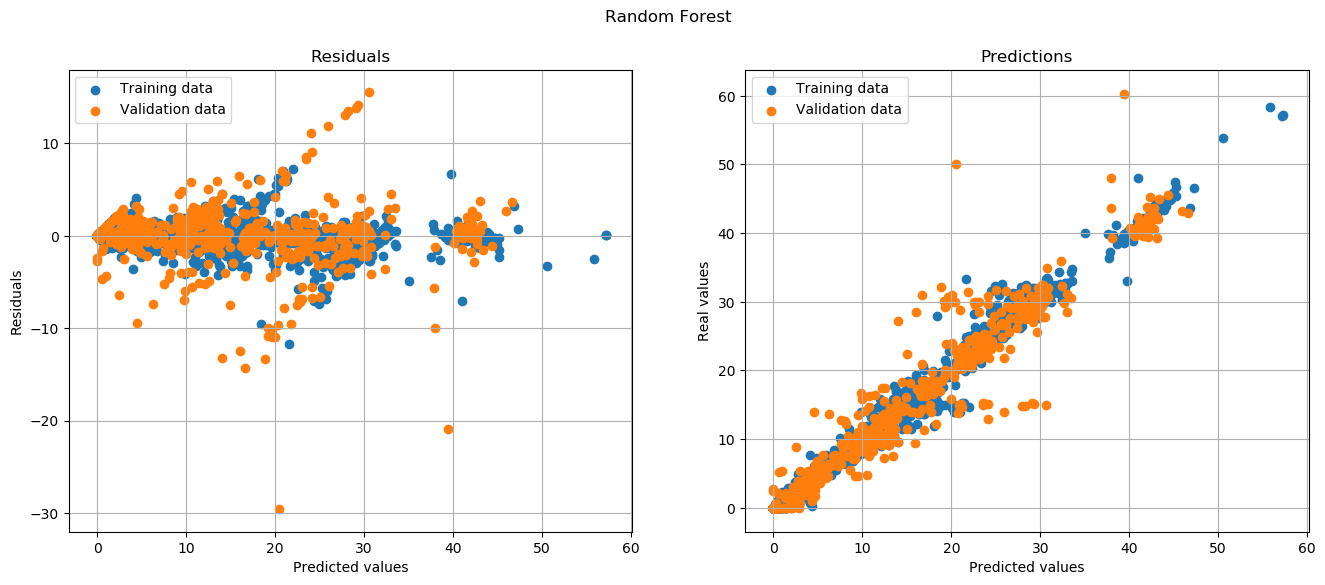

In [40]:
make_prediction(rf, 'Random Forest', X_train_v1, X_test_v1, y_train_v1, y_test_v1,'rf_pred_2.png')

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

Stabilizers (boolean)    0.009403
Current (nm/h)           0.010008
Speed (nm/h)             0.961604
Wind speed (m/s)         0.018985
dtype: float64


Text(0.5,1,'Coefficients in the Random Forest')

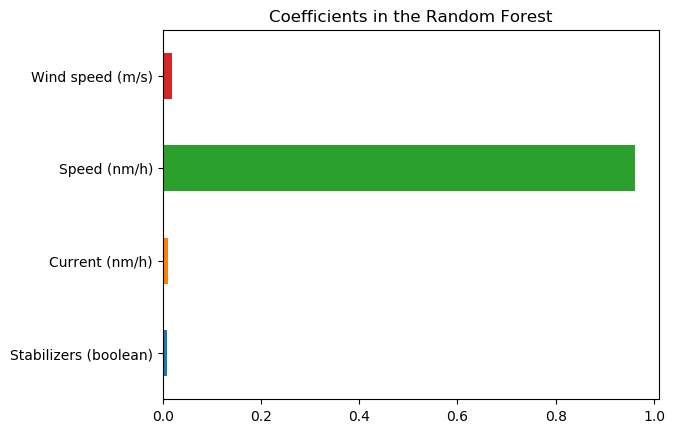

In [41]:
rf.fit(X_train_v1, y_train_v1)
# Plot important features
coefs = pd.Series(rf.feature_importances_, index = X_train_v1.columns)
print(coefs)
# print("classifer picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
#       str(sum(coefs == 0)) + " features")
# imp_coefs = pd.concat([coefs.sort_values().head(10),
#                      coefs.sort_values().tail(10)])
imp_coefs = coefs
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Random Forest")
plt.show()

### V2

RMSE on Training set : 2.355225105216699
RMSE on Test set : 2.8771403516290737


array([<matplotlib.axes._subplots.AxesSubplot object at 0x2ae1215a7978>,
      dtype=object)

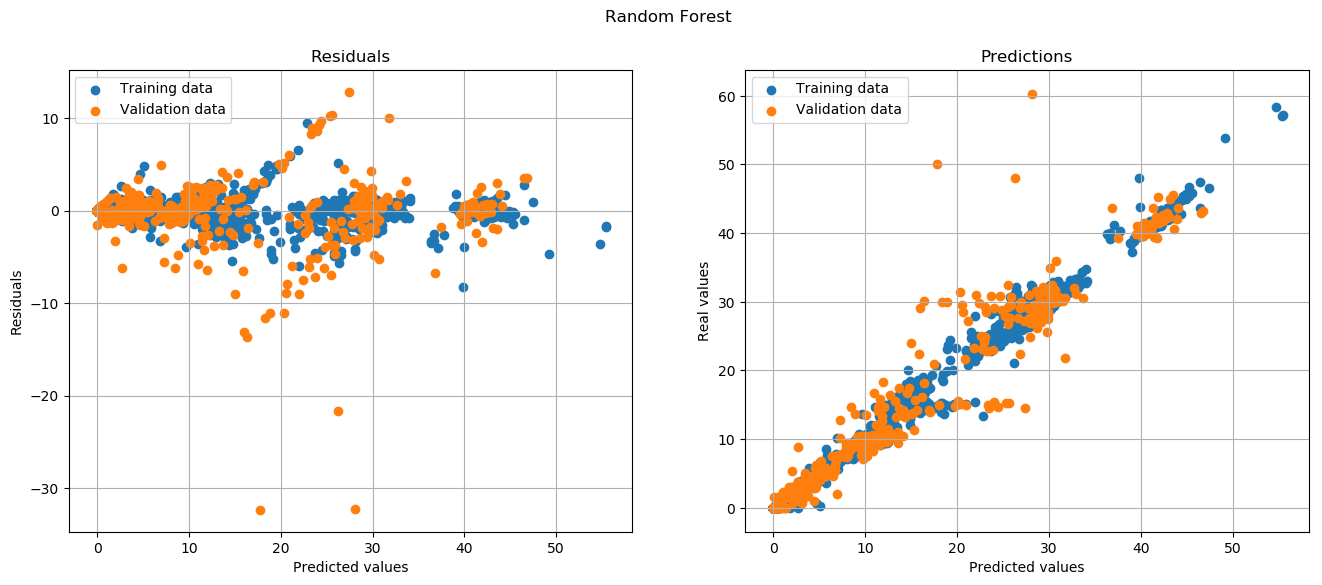

In [42]:
make_prediction(rf, 'Random Forest', X_train_v2, X_test_v2, y_train_v2, y_test_v2,'rf_pred_v2_2.png')

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

Stabilizers (boolean)        0.001454
Current (nm/h)               0.008149
Speed (nm/h)                 0.960169
Wind speed (m/s)             0.016827
Sea temperature (Celsius)    0.013401
dtype: float64


Text(0.5,1,'Coefficients in the Random Forest')

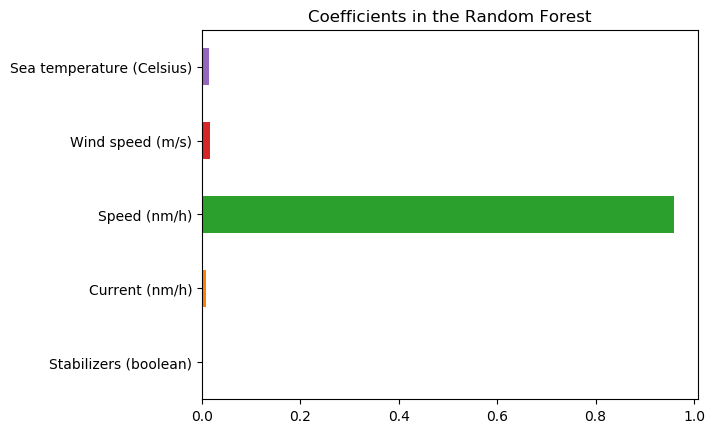

In [43]:
rf.fit(X_train_v2, y_train_v2)
# Plot important features
coefs = pd.Series(rf.feature_importances_, index = X_train_v2.columns)
print(coefs)
# print("classifer picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
#       str(sum(coefs == 0)) + " features")
# imp_coefs = pd.concat([coefs.sort_values().head(10),
#                      coefs.sort_values().tail(10)])
imp_coefs = coefs
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Random Forest")
plt.show()